# Exploratory Data Visualization
**First look what data you have and testing hunches**

NOTE: goal is to show benifit of fast and easy crossfiltering of large(ish) dataset

## Overview and Requirements
Super short version of intro notebook and restate requirments

## Imports


In [ ]:
import cuxfilter
import cudf
import cugraph
from pyproj import Proj, Transformer
from pathlib import Path

DATA_DIR = Path("../data")
FILENAME = Path("data.csv")

## Load Cleaned Data / Check

In [ ]:
data = cudf.read_csv(DATA_DIR / FILENAME)

## Intro to cuxfilter

Cuxfilter is part of the Nvidia RAPIDS suite of open source software libraries and APIs, that gives you the ability to execute end-to-end data science and analytics pipelines entirely on GPUs.

It acts as a connector library, which provides the connections between different visualization libraries and a GPU dataframe without much hassle. This also allows the user to use charts from different libraries in a single dashboard, while also providing the interaction.

## Charts 

### [API Documentation](https://docs.rapids.ai/api/cuxfilter/stable/charts/charts.html)


#### Example Dashboard 1

```python
import cuxfilter

#update data_dir if you have downloaded datasets elsewhere
DATA_DIR = './data'
from cuxfilter.sampledata import datasets_check
datasets_check('mortgage', base_dir=DATA_DIR)

cux_df = cuxfilter.DataFrame.from_arrow(DATA_DIR + '/146M_predictions_v2.arrow')

MAPBOX_API_KEY= "<mapbox-api-key>"
geoJSONSource='https://raw.githubusercontent.com/rapidsai/cuxfilter/GTC-2018-mortgage-visualization/javascript/demos/GTC%20demo/src/data/zip3-ms-rhs-lessprops.json'

chart0 = cuxfilter.charts.choropleth( x='zip', color_column='delinquency_12_prediction', color_aggregate_fn='mean',
            elevation_column='current_actual_upb', elevation_factor=0.00001, elevation_aggregate_fn='sum', 
            geoJSONSource=geoJSONSource, mapbox_api_key=MAPBOX_API_KEY, data_points=1000
)
chart2 = cuxfilter.charts.bar('delinquency_12_prediction',data_points=50)
chart3 = cuxfilter.charts.range_slider('borrower_credit_score',data_points=50)
chart1 = cuxfilter.charts.drop_down('dti')

#declare dashboard
d = cux_df.dashboard([chart0, chart2, chart3, chart1], layout=cuxfilter.layouts.feature_and_double_base,theme = cuxfilter.themes.light, title='Mortgage Dashboard')

#run the dashboard as a webapp:
d.show('jupyter-notebook/lab-url')
```

<div>
<img src="https://raw.githubusercontent.com/rapidsai/cuxfilter/branch-0.16/docs/_images/demo2.gif" width="800" height="500" style="margin-left:25%"/>
</div>

#### Example Dashboard 2

```python
import cuxfilter

#update data_dir if you have downloaded datasets elsewhere
DATA_DIR = './data'
from cuxfilter.sampledata import datasets_check
datasets_check('auto_accidents', base_dir=DATA_DIR)

cux_df = cuxfilter.DataFrame.from_arrow(DATA_DIR+'/auto_accidents.arrow')
cux_df.data['ST_CASE'] = cux_df.data['ST_CASE'].astype('float64')

label_map = {1: 'Sunday',    2: 'Monday',    3: 'Tuesday',    4: 'Wednesday',   5: 'Thursday',    6: 'Friday',    7: 'Saturday',    9: 'Unknown'}
gtc_demo_red_blue_palette = [ "#3182bd", "#6baed6", "#7b8ed8", "#e26798", "#ff0068" , "#323232" ]

#declare charts
chart1 = cuxfilter.charts.scatter(x='dropoff_x', y='dropoff_y', aggregate_col='DAY_WEEK', aggregate_fn='mean',
                                color_palette=gtc_demo_red_blue_palette, tile_provider='CARTODBPOSITRON',
                                pixel_shade_type='linear')
chart2 = cuxfilter.charts.multi_select('YEAR')
chart3 = cuxfilter.charts.bar('DAY_WEEK', x_label_map=label_map)
chart4 = cuxfilter.charts.bar('MONTH')

#declare dashboard
d = cux_df.dashboard([chart1, chart2, chart3, chart4], layout=cuxfilter.layouts.feature_and_double_base, title='Auto Accident Dataset')
#run the dashboard as a webapp:
d.show('jupyter-notebook/lab-url')
```

<div>
<img src="https://raw.githubusercontent.com/rapidsai/cuxfilter/branch-0.16/docs/_images/demo.gif" width="800" height="500" style="margin-left:25%"/>
</div>


## Data Preprocessing

#### Extract Edges

In [ ]:
G = cugraph.Graph() 
G.from_cudf_edgelist(data, source='from_station_id', destination='to_station_id')
edges = G.edges()

In [ ]:
edges.head()

#### Transform the coordinates to overlay it on top of a map in cuxfilter

In [ ]:
def transform_coords(df, x='x', y='y'):
    # Apply transformation
    transform_4326_to_3857 = Transformer.from_crs('epsg:4326', 'epsg:3857')
    df['x'], df['y'] = transform_4326_to_3857.transform(df[x].to_array(), df[y].to_array())
    return df

trips = transform_coords(data, x='latitude_start', y='longitude_start')

#### Extract day_type from the dataset (weekend / weekday)

In [ ]:
trips['day_type'] = 0
#day =5 or 6 is weekend
trips.loc[trips.query('day>4').index, 'day_type'] = 1

#### Get global week number in the dataset

In [ ]:
year0 = int(trips.year.min()) #2014

"""
trips.groupby('year').week.max().to_pandas().to_dict() is
{2014: 52, 2015: 53, 2016: 53, 2017: 52}

Since 2015 and 2016 have 53 weeks, we add 1 to global week count for their following years - 2016 & 2017

(data.year/2016).astype('int') => returns 1 if year>=2016, else 0
"""
trips['all_time_week'] = data.week + 52*(data.year - year0) + (data.year/2016).astype('int')

In [ ]:
trips.head()

## cuxfilter example 1

In [ ]:
cux_df = cuxfilter.DataFrame.from_dataframe(data)

In [ ]:
charts = [
    cuxfilter.charts.bar('hour', title='trips per hour'),
    cuxfilter.charts.bar('month'),
    cuxfilter.charts.bar('day'),
    cuxfilter.charts.multi_select('year'),
]

#trips per hour
d = cux_df.dashboard(charts, layout=cuxfilter.layouts.feature_and_double_base, title='Bike Trips Dashboard')

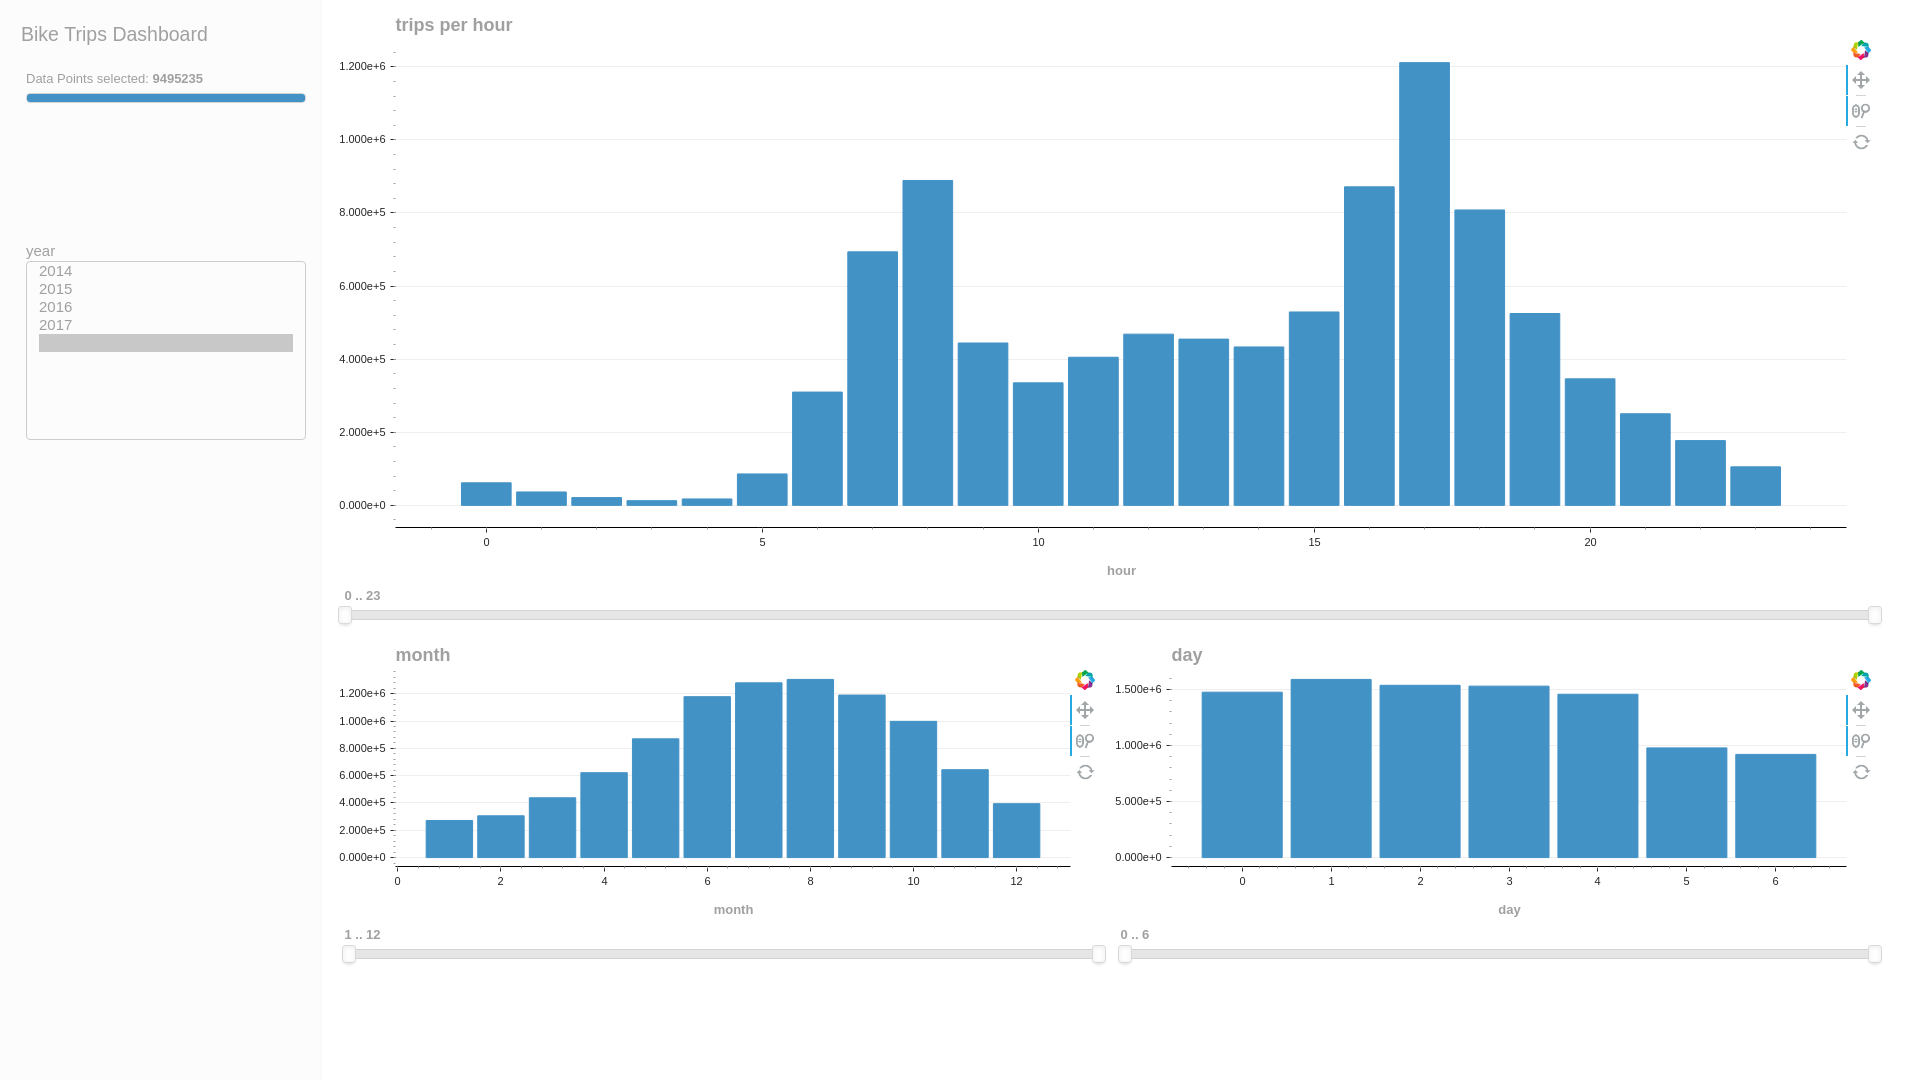

In [68]:
await d.preview()
# d.show() #default parameter -> notebook_url="http://localhost:8888"

## cuxfilter example 2

In [ ]:
chart0 = cuxfilter.charts.bar('all_time_week', title='rides per week')
chart6 = cuxfilter.charts.heatmap(x='all_time_week', y='day', aggregate_col='temperature', aggregate_fn='mean', point_size=40, legend_position='right', title='mean temperature')

d = cux_df.dashboard([chart6, chart0], layout=cuxfilter.layouts.feature_and_base)

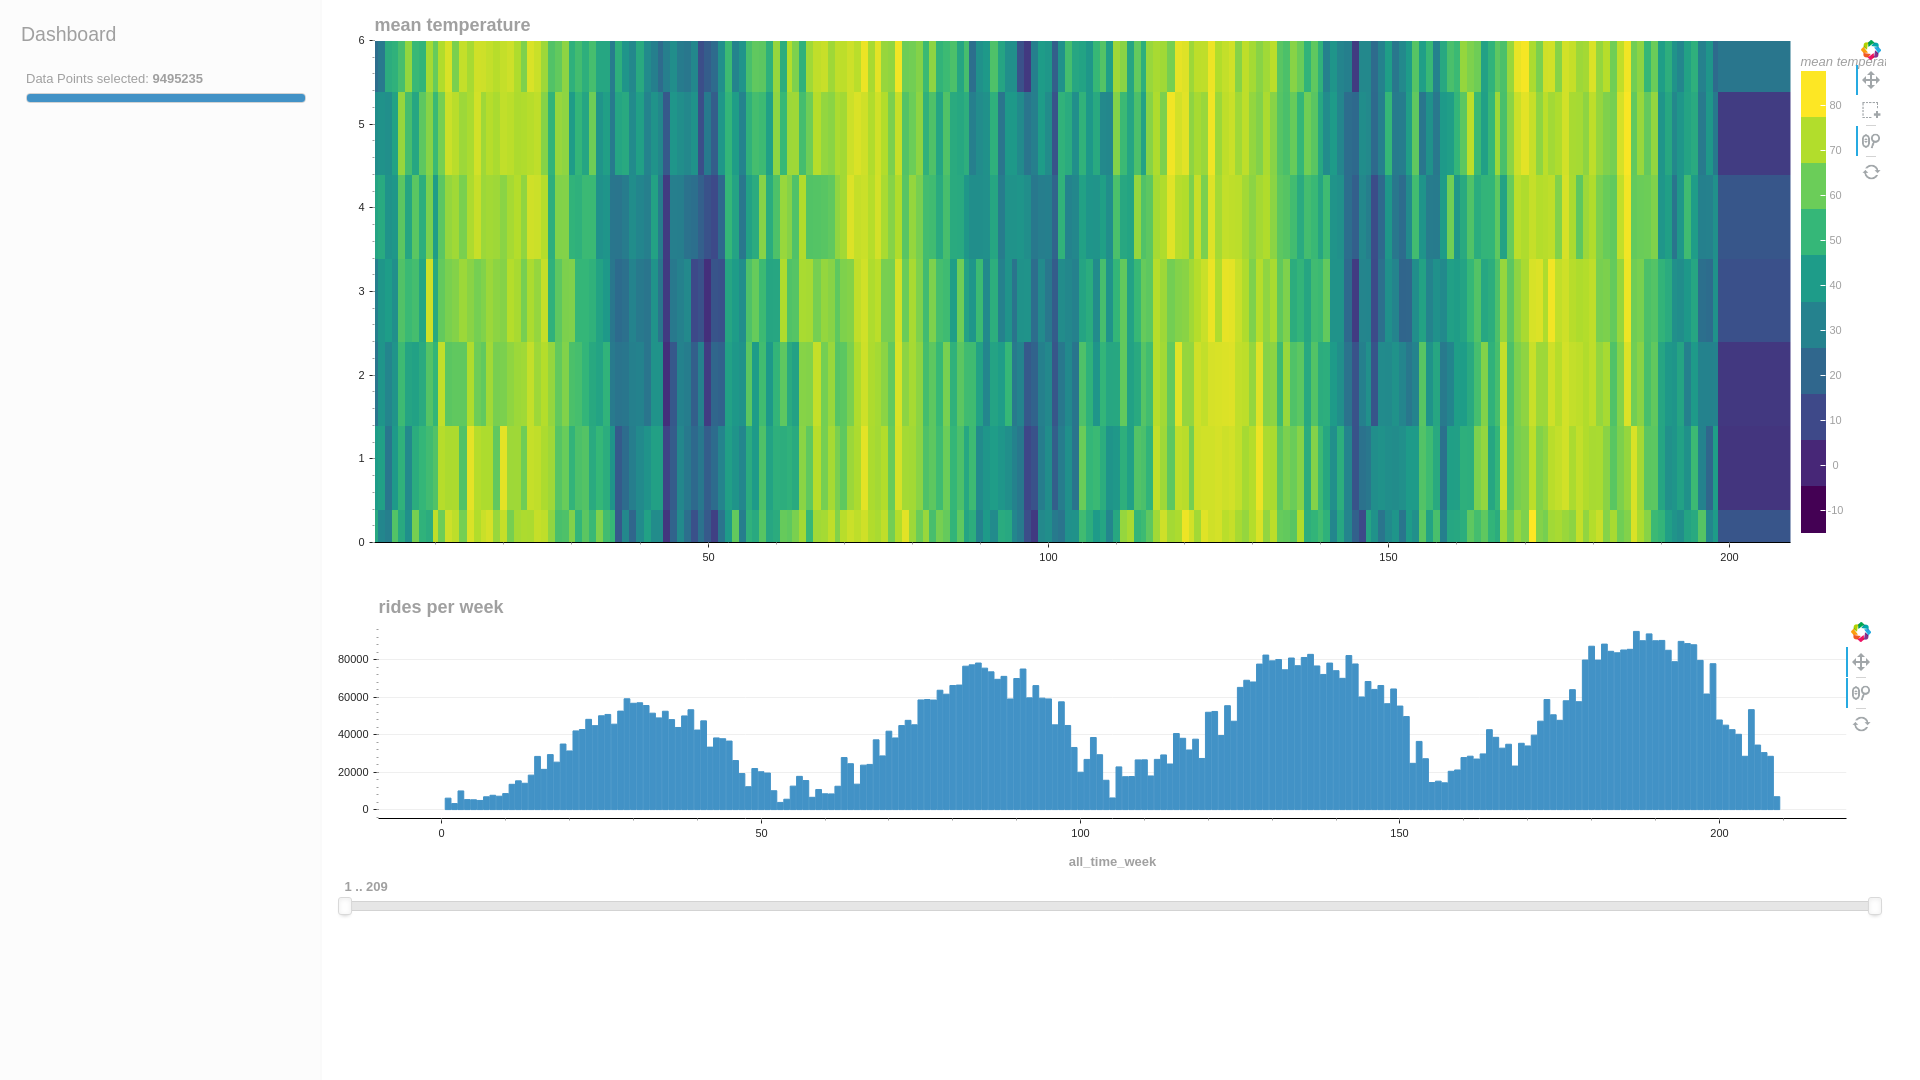

In [70]:
await d.preview()
# d.show() #default parameter -> notebook_url="http://localhost:8888"

## cuxfilter example 3

In [ ]:
cux_df = cuxfilter.DataFrame.load_graph((trips, edges))

In [ ]:
charts = [
    cuxfilter.charts.graph(node_id='from_station_id',
                        edge_source='src', edge_target='dst',
                        node_aggregate_fn='mean', node_aggregate_col='day_type', node_color_palette=['green', 'blue'],
                        node_pixel_shade_type='linear', node_point_size=35,
                        edge_render_type='direct',#other option available -> 'curved'
                        edge_transparency=0.5, tile_provider='CARTODBPOSITRON', title='Graph for trip source_stations (color by more trips on weekend/weekdays)'
                      ),
    cuxfilter.charts.multi_select('year'),
    cuxfilter.charts.multi_select('day_type', label_map={0:'weekday', 1:'weekend', '':'all'}),
    cuxfilter.charts.bar('from_station_id'),
    cuxfilter.charts.bar('to_station_id'),
    cuxfilter.charts.view_dataframe(['from_station_name', 'to_station_name', 'year'])
]

In [ ]:
d = cux_df.dashboard(charts, layout=cuxfilter.layouts.feature_and_triple_base, theme=cuxfilter.themes.rapids)

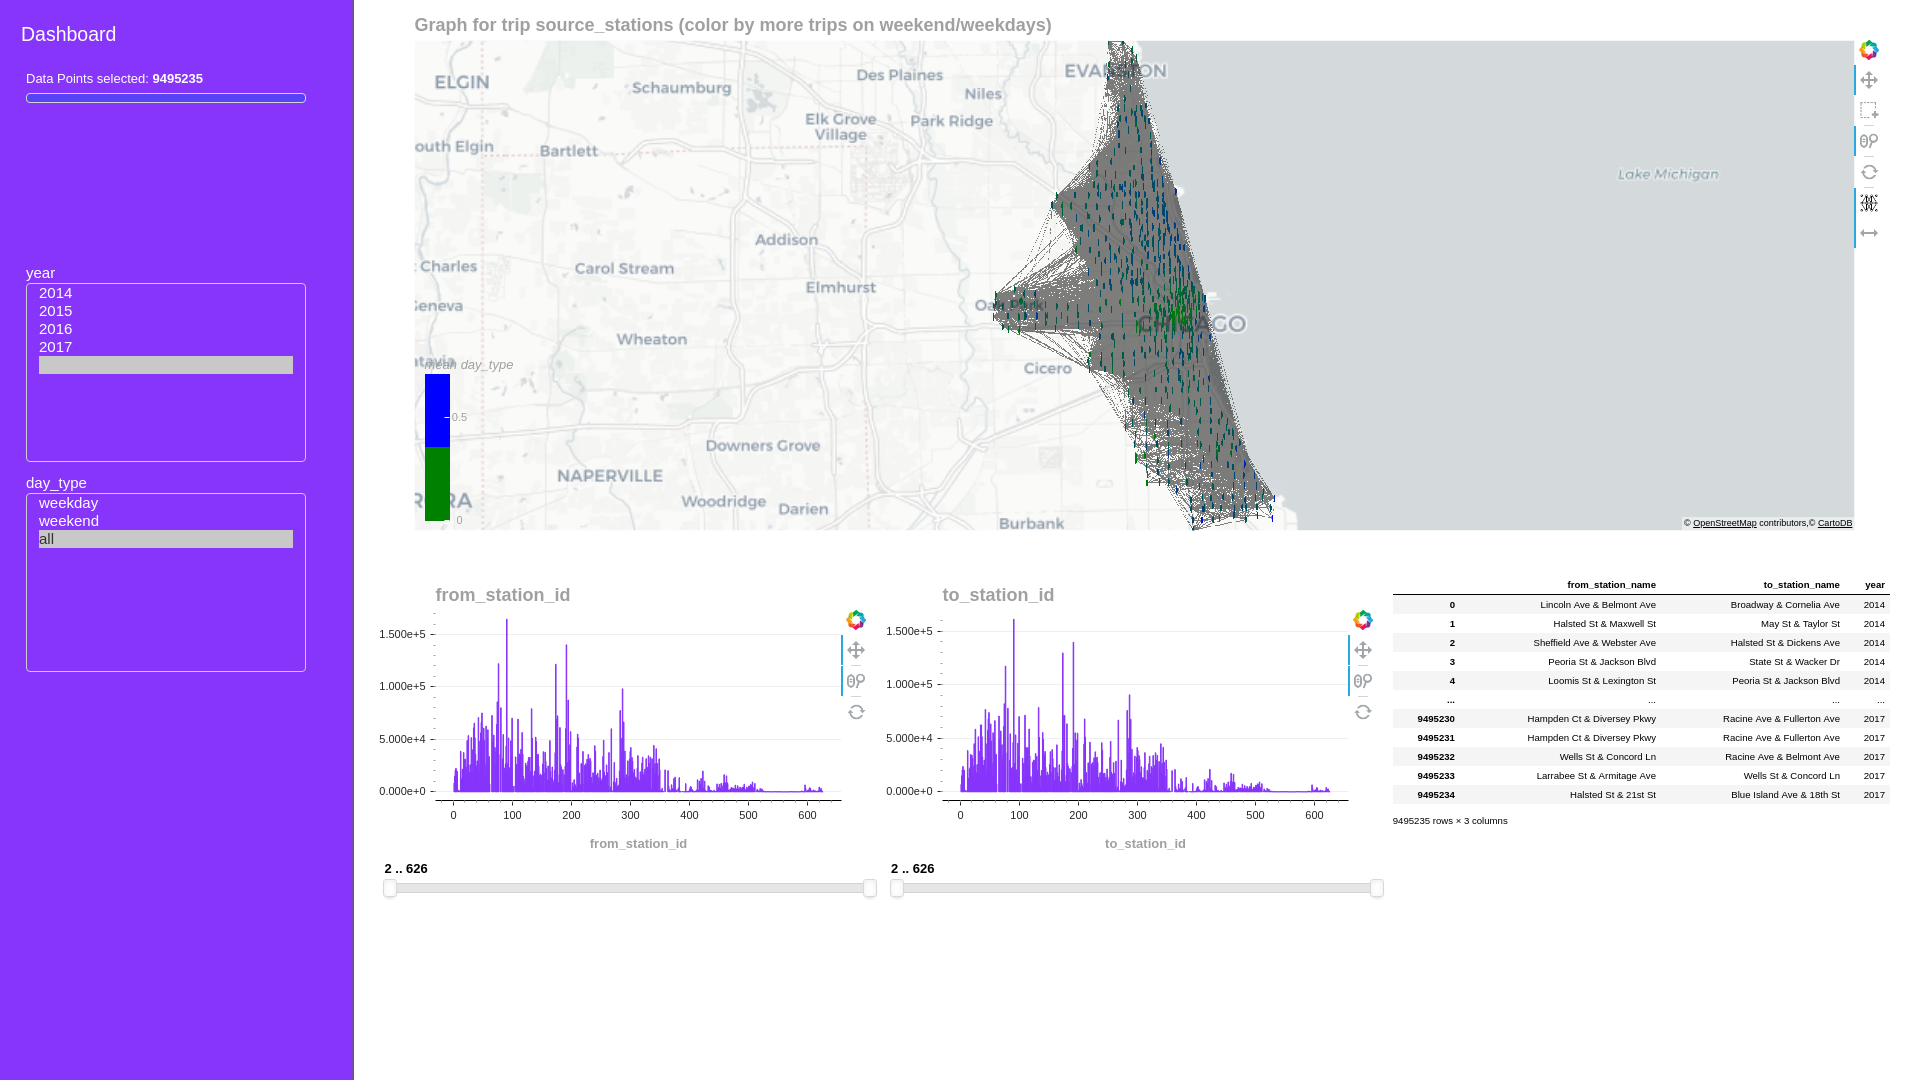

In [65]:
await d.preview()
# d.show() #default parameter -> notebook_url="http://localhost:8888"

## cuxfilter example 4

#### Using force_atlas2 from cugraph to check important stations (non_geo spatial layout)

In [ ]:
G = cugraph.Graph() 
G.from_cudf_edgelist(trips, source='from_station_id', destination='to_station_id')
edges = G.edges()

In [72]:
edges.head()

,src,dst
0,126,129
1,126,294
2,126,459
3,126,180
4,126,188


In [ ]:
ITERATIONS=500
THETA=1.0
OPTIMIZE=True

trips_force_atlas2_layout = cugraph.layout.force_atlas2(G, max_iter=100,
                strong_gravity_mode=False,
                outbound_attraction_distribution=True,
                lin_log_mode=False,
                barnes_hut_optimize=OPTIMIZE, barnes_hut_theta=THETA, verbose=True)

In [ ]:
final_df = trips_force_atlas2_layout.merge(
                trips[['from_station_id', 'from_station_name', 'year', 'hour', 'day_type']],
                left_on='vertex',
                right_on='from_station_id'
)

final_df = final_df[trips_force_atlas2_layout.columns.tolist() + ['from_station_id', 'from_station_name', 'year', 'hour', 'day_type']]
final_df.columns = trips_force_atlas2_layout.columns.tolist() + ['from_station_id','station_name', 'year', 'hour', 'day_type']

In [75]:
final_df.head()

,x,y,vertex,from_station_id,station_name,year,hour,day_type
0,-215.544861,86.893982,286,286,Franklin St & Quincy St,2014,16,0
1,21.877483,395.534180,100,100,Orleans St & Merchandise Mart Plaza,2014,16,0
2,-608.204651,338.987396,338,338,Calumet Ave & 18th St,2014,16,0
3,118.487808,512.439026,85,85,Michigan Ave & Oak St,2014,16,0
4,21.877483,395.534180,100,100,Orleans St & Merchandise Mart Plaza,2014,16,0


In [ ]:
cux_df = cuxfilter.DataFrame.load_graph((final_df, edges))

In [ ]:
charts= [
  cuxfilter.charts.graph(
      edge_source='src', edge_target='dst', edge_color_palette=['gray', 'black'],node_pixel_shade_type='linear',
      node_color_palette=['green', 'blue'], node_aggregate_col='day_type', node_aggregate_fn='mean',
  ),
  cuxfilter.charts.multi_select('year'),
  cuxfilter.charts.multi_select('day_type', label_map={0:'weekday', 1:'weekend', '':'all'}),
  cuxfilter.charts.bar('hour', title='trips per hour'),
  cuxfilter.charts.bar('from_station_id'),
  cuxfilter.charts.view_dataframe(['from_station_id', 'station_name', 'year'])
] 
d = cux_df.dashboard(charts, layout=cuxfilter.layouts.feature_and_triple_base, theme=cuxfilter.themes.rapids)

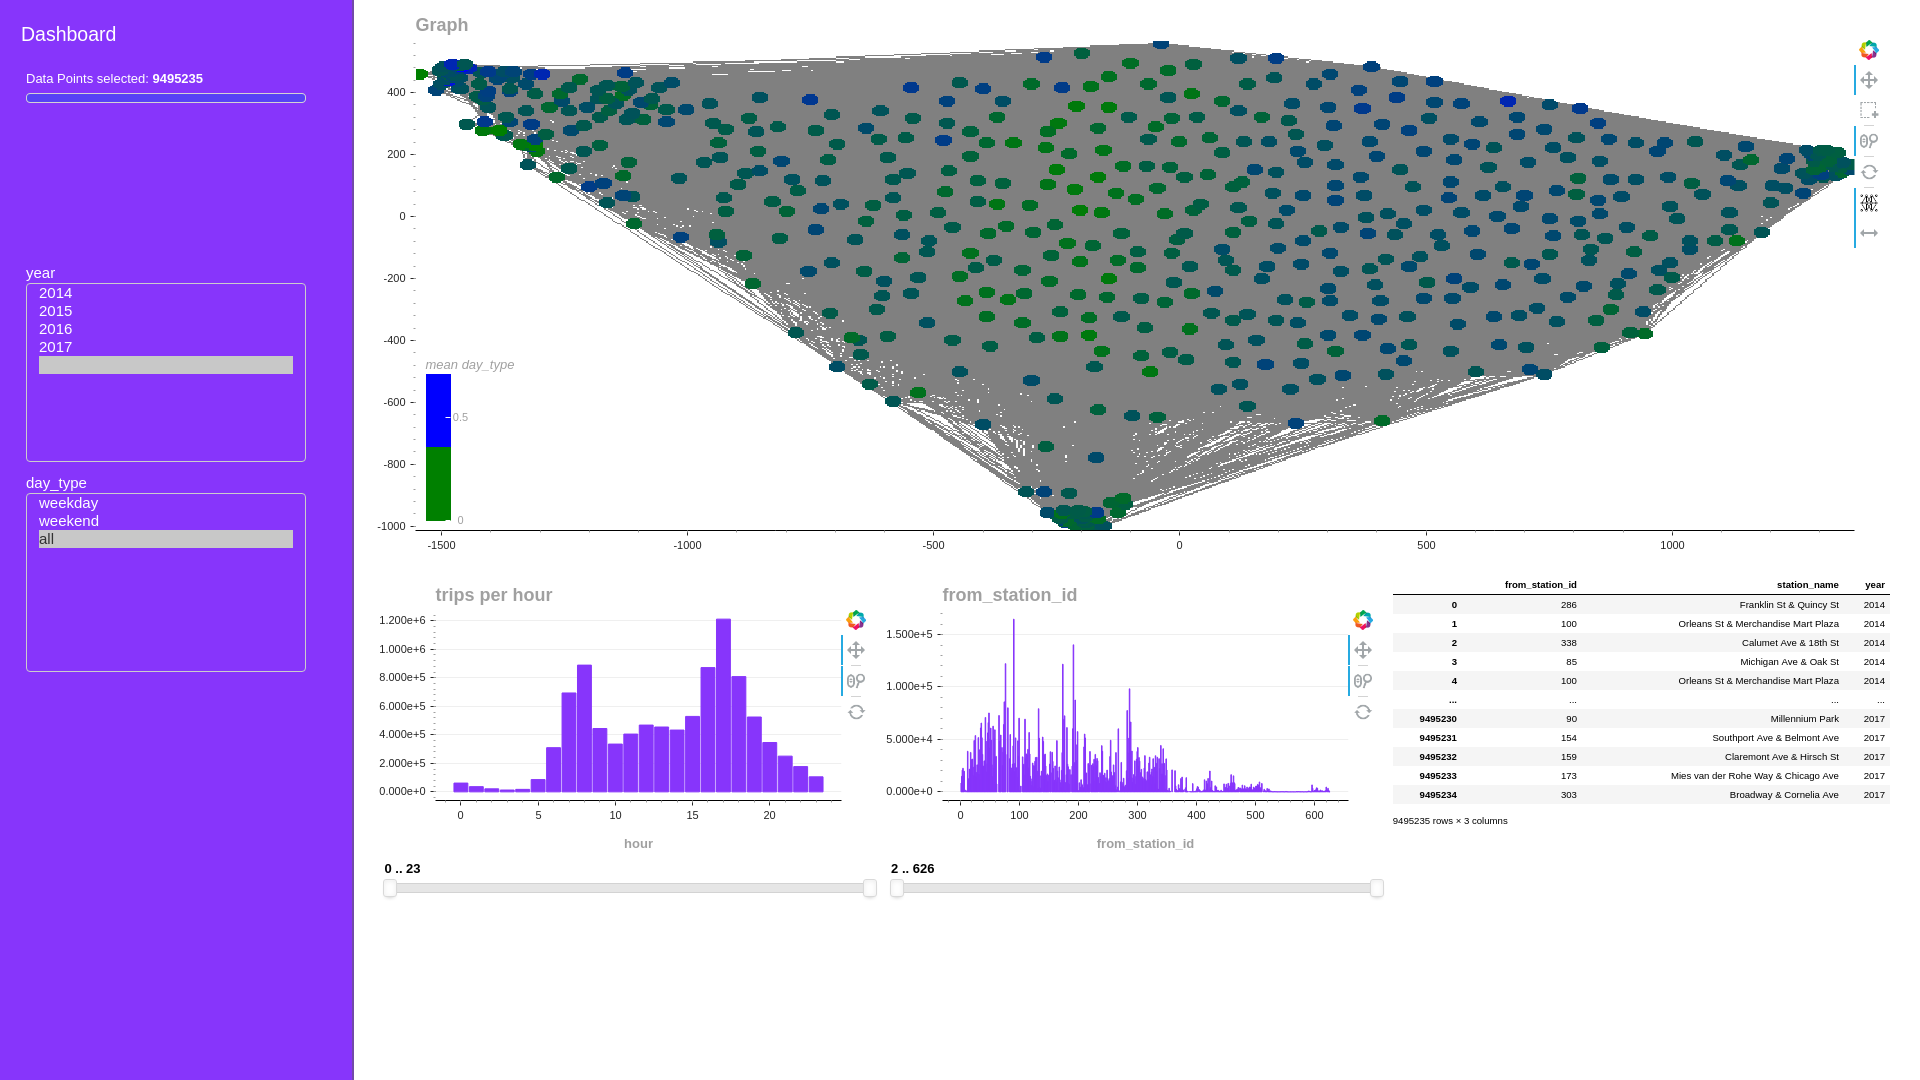

In [78]:
await d.preview()
# d.show() #default parameter -> notebook_url="http://localhost:8888"

## summary of interesting exploratory findings
list of interesting patterns we found and want to continue to explore